In [1]:
# starting code
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### Architecture of a classification neural network

| Hyperparameter                    | Binary Classification                                                                                        | Multiclass classification                                                                                                        |
| --------------------------------- | ------------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------- |
| Input layer shape (in_features)   | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification                                                                                                    |
| Hidden layer(s)                   | Problem specific, minimum = 1, maximum = unlimited                                                           | Same as binary classification                                                                                                    |
| Neurons per hidden layer          | Problem specific, generally 10 to 512                                                                        | Same as binary classification                                                                                                    |
| Output layer shape (out_features) | 1 (one class or the other)                                                                                   | 1 per class (e.g. 3 for food, person or dog photo)                                                                               |
| Hidden layer activation           | Usually ReLU (rectified linear unit) but can be many others                                                  | Same as binary classification                                                                                                    |
| Output activation                 | Sigmoid (torch.sigmoid in PyTorch)                                                                           | Softmax (torch.softmax in PyTorch)                                                                                               |
| Loss function                     | Binary crossentropy (torch.nn.BCELoss in PyTorch)                                                            | [Cross entropy (torch.nn.CrossEntropyLoss in PyTorch)](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Optimizer                         | SGD (stochastic gradient descent), Adam (see torch.optim for more options)                                   | Same as binary classification                                                                                                    |


### Preparing data

In [2]:
from sklearn.datasets import make_circles

# Make 10000 samples 
n_samples = 10000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=13) # keep random state so we get the same values

In [3]:
# 2 features per 1 y value
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.29995149  0.73901664]
 [-0.57678771  0.77565796]
 [ 0.96338061 -0.25824735]
 [ 0.97059622  0.20609374]
 [-0.77483082  0.35649152]]

First 5 y labels:
[1 0 0 0 1]


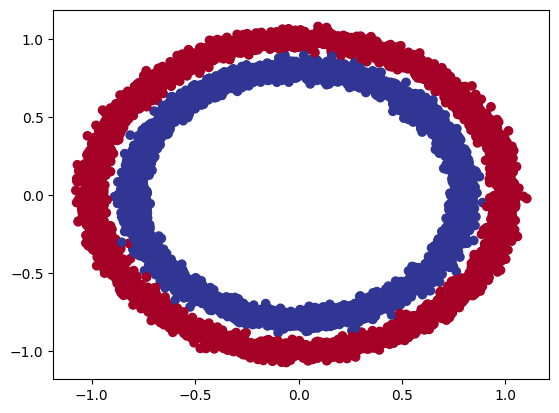

In [4]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

### Prepare train and test data

In [5]:
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, 
                                                    y_tensor, 
                                                    stratify=y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=13) # make the random split reproducible

print(len(X_train), len(X_test), len(y_train), len(y_test))
print(y_train.sum()/len(y_train), y_test.sum()/len(y_test))

8000 2000 8000 2000
tensor(0.5000) tensor(0.5000)


In [6]:
# Getting input and output shapes correct
print(X_train.shape, y_train.shape)

torch.Size([8000, 2]) torch.Size([8000])


### Defining the model

In [7]:
class CircleClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Create 2 nn.Linear layers, first layer takes in shape of X (i.e. 2), layer 2 output into shape of y
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 2. Define the forward method - i.e. how is each record of x computed
    def forward(self, x):
        layer_1_output = self.layer_1(x)
        return self.layer_2(layer_1_output)

model_0 = CircleClassificationModel()
model_0.to(device)

CircleClassificationModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [8]:
# logits → nn.BCEWithLogitsLoss
# logits → sigmoid → nn.BCELoss
# in this example, we have not applied a sigmoid transformation, so use BCEWithLogitsLoss
loss_fn = nn.BCEWithLogitsLoss() 

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [9]:
# Evaluation metric

# Calculate accuracy (a classification metric)
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### Model training

In [10]:
epochs = 1000
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# pytorch training loop
def training(model, epochs):
    for epoch in range(epochs):
        ### MODEL TRAINING

        # 0. Put model in training mode
        model.train()
        
        # 1. Forward pass
        y_train_logits = model(X_train).squeeze() # the output has shape (n, 1), squeeze to turn it into just shape (n)
        y_train_pred = torch.round(torch.sigmoid(y_train_logits)) # use sigmoid to get probabilities, then rounding to get 0s & 1s

        # 2. Calculate loss
        loss = loss_fn(y_train_logits, y_train)
        
        # 3. zero gradients - optimizer gradients are set to zero so they can be recalcualted for the specific training step
        optimizer.zero_grad()

        # 4. Backpropagation on loss -  calculate loss gradients
        loss.backward()

        # 5. Update the parameters (every model parameter with requires_grad = True) with respect to the loss gradients
        optimizer.step()
            
        ### MODEL Testing
        # 0. Put model in evaluation mode
        model.eval()

        # 1. use inference mode to do predictions on test data
        with torch.inference_mode():
            y_test_pred_logits = model(X_test).squeeze()
            y_test_pred = torch.round(torch.sigmoid(y_test_pred_logits))
            test_loss = loss_fn(y_test_pred_logits, y_test) 
            test_accuracy = accuracy_fn(y_test_pred, y_test)

            if epoch % 50 == 0:
                epoch_count.append(epoch)
                train_loss_values.append(loss.item())
                test_loss_values.append(test_loss.item())
                print(f"Step {epoch}: training loss is {loss}, test loss is {test_loss}, test_accuracy is {test_accuracy}")

training(model=model_0, epochs=epochs)

Step 0: training loss is 0.6973240971565247, test loss is 0.6950325965881348, test_accuracy is 44.1
Step 50: training loss is 0.6937783360481262, test loss is 0.692709743976593, test_accuracy is 51.2
Step 100: training loss is 0.6933921575546265, test loss is 0.6928554773330688, test_accuracy is 50.849999999999994
Step 150: training loss is 0.6932597756385803, test loss is 0.693026602268219, test_accuracy is 51.1
Step 200: training loss is 0.6932094097137451, test loss is 0.6931527853012085, test_accuracy is 50.6
Step 250: training loss is 0.69318687915802, test loss is 0.6932345032691956, test_accuracy is 50.1
Step 300: training loss is 0.6931742429733276, test loss is 0.6932848691940308, test_accuracy is 49.55
Step 350: training loss is 0.69316565990448, test loss is 0.693315327167511, test_accuracy is 49.15
Step 400: training loss is 0.6931588649749756, test loss is 0.6933338642120361, test_accuracy is 49.55
Step 450: training loss is 0.6931533217430115, test loss is 0.6933454871177

### investigate poor performance

In [11]:
# helper functions from Learn PyTorch for Deep Learning repo - https://github.com/mrdbourke/pytorch-deep-learning 

from helper_functions import plot_predictions, plot_decision_boundary

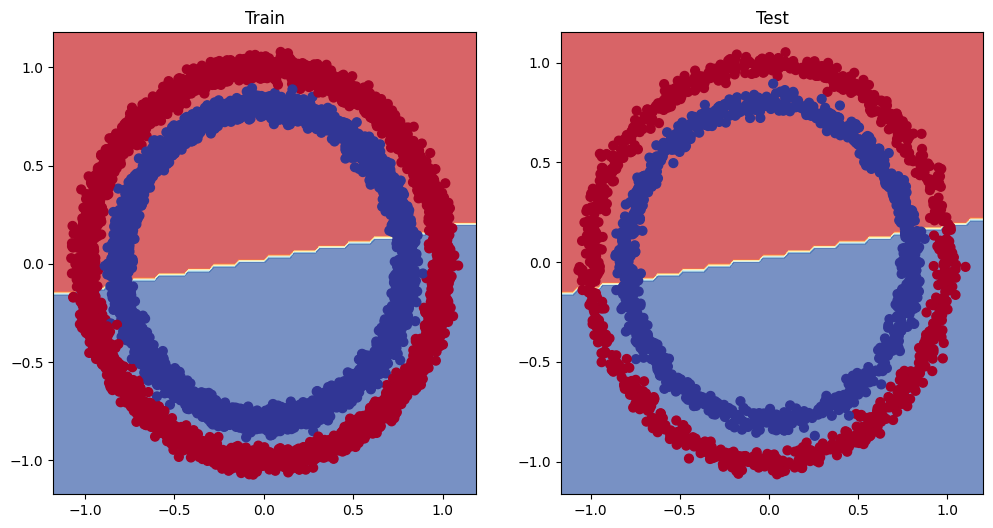

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Model is not performing well due to using only straight lines to fit the data

### Improving model performance

In [13]:
class CircleClassificationModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Create 2 nn.Linear layers, first layer takes in shape of X (i.e. 2), layer 2 output into shape of y
        self.layer_1 = nn.Linear(in_features=2, out_features=10) 
        self.layer_2 = nn.Linear(in_features=10, out_features=10) 
        self.layer_3 = nn.Linear(in_features=10, out_features=1) 
        self.relu = nn.ReLU()
    
    # 2. Define the forward method - i.e. how is each record of x computed
    def forward(self, x):
        layer_1_output = self.relu(self.layer_1(x))
        layer_2_output = self.relu(self.layer_2(layer_1_output))
        return self.layer_3(layer_2_output)

model_1 = CircleClassificationModelV2()
model_1.to(device)

# Define loss function
loss_fn = nn.BCEWithLogitsLoss() 

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [14]:
from torchinfo import summary
summary(model_1, input_size=(1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
CircleClassificationModelV2              [1, 1]                    --
├─Linear: 1-1                            [1, 10]                   30
├─ReLU: 1-2                              [1, 10]                   --
├─Linear: 1-3                            [1, 10]                   110
├─ReLU: 1-4                              [1, 10]                   --
├─Linear: 1-5                            [1, 1]                    11
Total params: 151
Trainable params: 151
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [15]:
epochs = 2000
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# pytorch training loop
training(model=model_1, epochs=epochs)

Step 0: training loss is 0.7023530006408691, test loss is 0.7015648484230042, test_accuracy is 50.0
Step 50: training loss is 0.6939589381217957, test loss is 0.6942763924598694, test_accuracy is 45.2
Step 100: training loss is 0.6933337450027466, test loss is 0.6936933398246765, test_accuracy is 47.25
Step 150: training loss is 0.6931125521659851, test loss is 0.693432629108429, test_accuracy is 47.699999999999996
Step 200: training loss is 0.6929534673690796, test loss is 0.6932240724563599, test_accuracy is 47.85
Step 250: training loss is 0.6927812099456787, test loss is 0.6930025219917297, test_accuracy is 48.65
Step 300: training loss is 0.6925383806228638, test loss is 0.6927076578140259, test_accuracy is 49.5
Step 350: training loss is 0.6923093199729919, test loss is 0.6924288868904114, test_accuracy is 53.949999999999996
Step 400: training loss is 0.6920793652534485, test loss is 0.6921491622924805, test_accuracy is 59.8
Step 450: training loss is 0.6918076872825623, test los

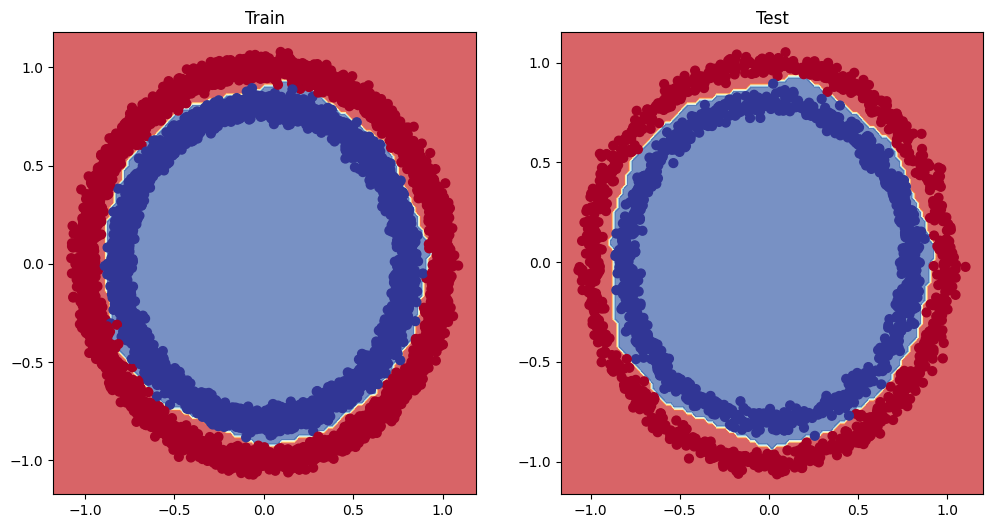

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)